In [1]:
#include <iostream>
#include <xtensor/xarray.hpp>
#include <xtensor/xio.hpp>
#include <xtensor/xview.hpp>
#include <xtensor/xarray.hpp>
#include <xtensor/xfixed.hpp>
#include <xtensor/xio.hpp>
#include <xtensor/xtensor.hpp>
#include <xtensor/xadapt.hpp>
#include <xtensor/xarray.hpp>
#include <xtensor/xaxis_slice_iterator.hpp>
#include <xtensor/xaxis_iterator.hpp>
#include <xtensor/xio.hpp>
#include <xtensor/xarray.hpp>
#include <xtensor/xindex_view.hpp>
#include <xtensor/xchunked_array.hpp>
#include <xtensor/xfixed.hpp>
#include <cstddef>
#include <vector>
#include <xtensor/xarray.hpp>
#include <xtensor/xadapt.hpp>
#include <istream>
#include <fstream>
#include <iostream>
#include <xtensor/xarray.hpp>
#include <xtensor/xcsv.hpp>
#include <iostream>
#include <fstream>
#include <functional>
#include <cstdio>
#include <xtensor/xcsv.hpp>

using namespace xt;
using namespace std;

# Load data

In [2]:
using namespace std;

ifstream input_file;
input_file.open ("../data/R15_dataset.txt");
auto data = xt::load_csv<double>(input_file);
input_file.close();

data.reshape(data.shape());
xarray<double> X = view(data, all(), range(0, 2));

# Similarity

In [3]:
float euclidean_distance(const xarray<double>& a, const xarray<double>& b){ 
    return (float) sqrt(sum(pow((a - b), 2))(0));
}

# Clusterization

In [4]:
auto dbscan(const xarray<float>& X, float epsilon, int minPts)
{
    printf("%f,start log,,,\n",(double) time(nullptr) * 1000);

    // each data point can be in one of 3 stages
    int NOT_VISITED = -1; // not visited point
    int VISITED = 0; // non-core point
    int CLUSTERED = 1; // core point

    // initial setup
    int n = X.shape()[0];
    xarray<double> cluster = ones<double>({n}) * -1; // cluster register
    xarray<double> state = ones<double>({n}) * NOT_VISITED; // state register
    int cluster_id = 1;
    
    auto get_neighbors = [&] (int current_index) {
        list<int> neighbor_indices = list<int>();
        for (int neighbor_index : arange(0, n)){
            if (euclidean_distance(row(X, neighbor_index), row(X, current_index)) <= (float) epsilon){
                neighbor_indices.push_back((int) neighbor_index);
            };
        }
        return neighbor_indices;
    };
    
    // extend cluster
    function < void( int ) > search = [&] (int current_index) -> void {

        list<int> neighbor_indices = get_neighbors(current_index);
        printf("%f,Eps_time,%d,1,\n",(double) time(nullptr) * 1000, current_index);
        printf("%f,|Eps_neighbors|,%d,%d,\n",(double) time(nullptr) * 1000, current_index, (int) neighbor_indices.size());
        printf("%f,Eps_neighbor_id,%d,,",(double) time(nullptr) * 1000, current_index);
        for(auto& i : neighbor_indices) {std::cout << i << ";"; }
        printf("\n");

        if ((int) neighbor_indices.size() >= minPts){
            state(current_index) = CLUSTERED;
            cluster(current_index) = cluster_id;
            for (auto& neighbor_index : neighbor_indices) {
                if (state(neighbor_index) == VISITED || state(neighbor_index) == NOT_VISITED){
                    state(neighbor_index) = CLUSTERED;
                    cluster(neighbor_index) = cluster_id;
                    printf("%f,similarity_calculation,%d,1,\n",(double) time(nullptr) * 1000, current_index);
                    search(neighbor_index);
                };
            };
        } else {
            state(current_index) = VISITED;
        };
    };

    while (any(equal(state, NOT_VISITED))){
        xarray<int> idx = from_indices(argwhere(equal(state, NOT_VISITED)));
        search(idx(0,0));
        cluster_id++;
    }
    printf("%f,stop log,,,\n",(double) time(nullptr) * 1000);
    return cluster;
}

auto y_pred = dbscan(X, 0.7, 3);
// y_pred

# Save output to csv

In [5]:
ofstream out_file;
out_file.open ("../out/dbscan_cpp_R15_dataset.csv");
dump_csv(out_file, view(y_pred, all(), newaxis()));
out_file.close();

# To execute following cells change kernel into python 

In [1]:
cd ..

/work


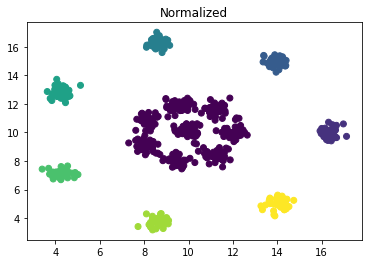

In [3]:
import pandas as pd
from src.datasets import Dataset
from src.utils import *

dataset = Dataset('./data/R15_dataset.txt')
X, y = dataset.X, dataset.y
c = pd.read_csv("./out/dbscan_cpp_R15_dataset.csv", header=None)
display_points(X, c, 'Normalized', numerate=False)